# **Exploring the effect of various external factors on Weekly Sales of Walmart Stores**

---

Group Members: Mu Ye Liu and 3 others.

---

In [38]:
## Load the necessary R packages
library(car)
library(ggcorrplot)
library(gridExtra)
library(dplyr)
library(ggplot2)

---

## **Introduction**

#### **About the Dataset**

The data we are analyzing is obtained from Kaggle, with link: https://www.kaggle.com/datasets/mikhail1681/walmart-sales?resource=download.

This dataset contains information on 45 Walmart stores across multiple regions, with data mostly collected between the through time between the years of 2010 - 2012. Each entry represented a week, where the weekly sales of the store in USD (our response variable) and other external factors such as average temperature, fuel price, whether or not a holiday existed throughout the week, etc are also recorded. This dataset was scraped from the official website of Amazon through BeautifulSoup and WebDriver using Python. 

#### **Motivation for analysis**

Analyzing this dataset can reveal insights into the factors influencing retail sales at Walmart, such as holidays, weather, and broader economic conditions. Understanding these relationships is valuable for developing data-driven strategies to optimize inventory, staffing, and marketing efforts. Insights from this dataset may also provide predictive value to other retail businesses seeking to enhance their sales forecasting and adapt to economic fluctuations. 

#### **Load the Dataset**

In [9]:
# Load the data
data = read.csv("Walmart_Sales.csv") |> na.omit()

# Modify the contents of the data below
#############

# Change the temperature to celcius
data$Temperature = round((data$Temperature - 32)*(5/9), 2)

# Round the decimal places for the following columns
data$Fuel_Price = round(data$Fuel_Price, 2)
data$CPI = round(data$CPI, 2)
data$Weekly_Sales = round(data$Weekly_Sales, 0)

# Convert Holiday flag to factor (because it's categorical)
data$Holiday_Flag = factor(data$Holiday_Flag)

# Print out a summary of the first and last lines.
head(data)
tail(data)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
,<int>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,05-02-2010,1643691,0,5.73,2.57,211.10,8.106
2,1,12-02-2010,1641957,1,3.62,2.55,211.24,8.106
3,1,19-02-2010,1611968,0,4.41,2.51,211.29,8.106
4,1,26-02-2010,1409728,0,8.13,2.56,211.32,8.106
5,1,05-03-2010,1554807,0,8.06,2.62,211.35,8.106
6,1,12-03-2010,1439542,0,14.33,2.67,211.38,8.106


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
,<int>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
6430,45,21-09-2012,723086,0,18.51,4.04,191.86,8.684
6431,45,28-09-2012,713174,0,18.27,4.00,192.01,8.684
6432,45,05-10-2012,733455,0,18.27,3.98,192.17,8.667
6433,45,12-10-2012,734464,0,12.48,4.00,192.33,8.667
6434,45,19-10-2012,718126,0,13.59,3.97,192.33,8.667
6435,45,26-10-2012,760281,0,14.92,3.88,192.31,8.667


---

## **Description of Variables**

**Weekly_Sales** (*Continuous, Response variable*) - Weekly revenue generated from sales through the week in USD

**Holiday_Flag** (*Dummy Categorical, Covariate*) - Indicator for: holiday exists within the week (1) or no holidays exist within the week (0).

**Temperature** (*Continuous, Covariate*) - Average air temperature in the store’s region throughout the week which is originally in degrees fahrenheit. For our analysis, we converted it into degrees celcius

**Fuel_Price** (*Continuous, Covariate*) - Average cost of fuel in the store’s region USD per gallon throughout the week.

**CPI** (*Continuous, Covariate*) - Average Consumer Price Index throughout the week.

**Unemployment** (*Continous, Covariate*) - Average Unemployment rate (%) throughout the week.

---

## **Analysis**

### **Data Pre-Processing**

Since the original dataset comprises 6,435 observations from 45 stores, conducting regression analysis on the entire dataset would violate the assumption of independence (i.e., observations are independent of one another). This is due to the fact that weekly sales within the same store are highly dependent, as they are influenced by shared factors such as location, recurring customer behavior patterns, local economic conditions, and store-specific operational strategies.

Therefore, we decide to choose one store as a representative of all the stores, which can reflect the characteristics of all stores.

To select a store that represents the overall characteristics of all stores effectively, we identify the store with the median rank based on a combination of its average weekly sales and variance in weekly sales. The calculations were performed using a series of steps. First, summary statistics, including the mean and variance of weekly sales, were computed for each store. The sum of these two ranks was calculated to determine each store’s combined rank. Subsequently, the data was sorted based on the combined rank, and the store corresponding to the median rank was identified as the most representative.

[1] 40


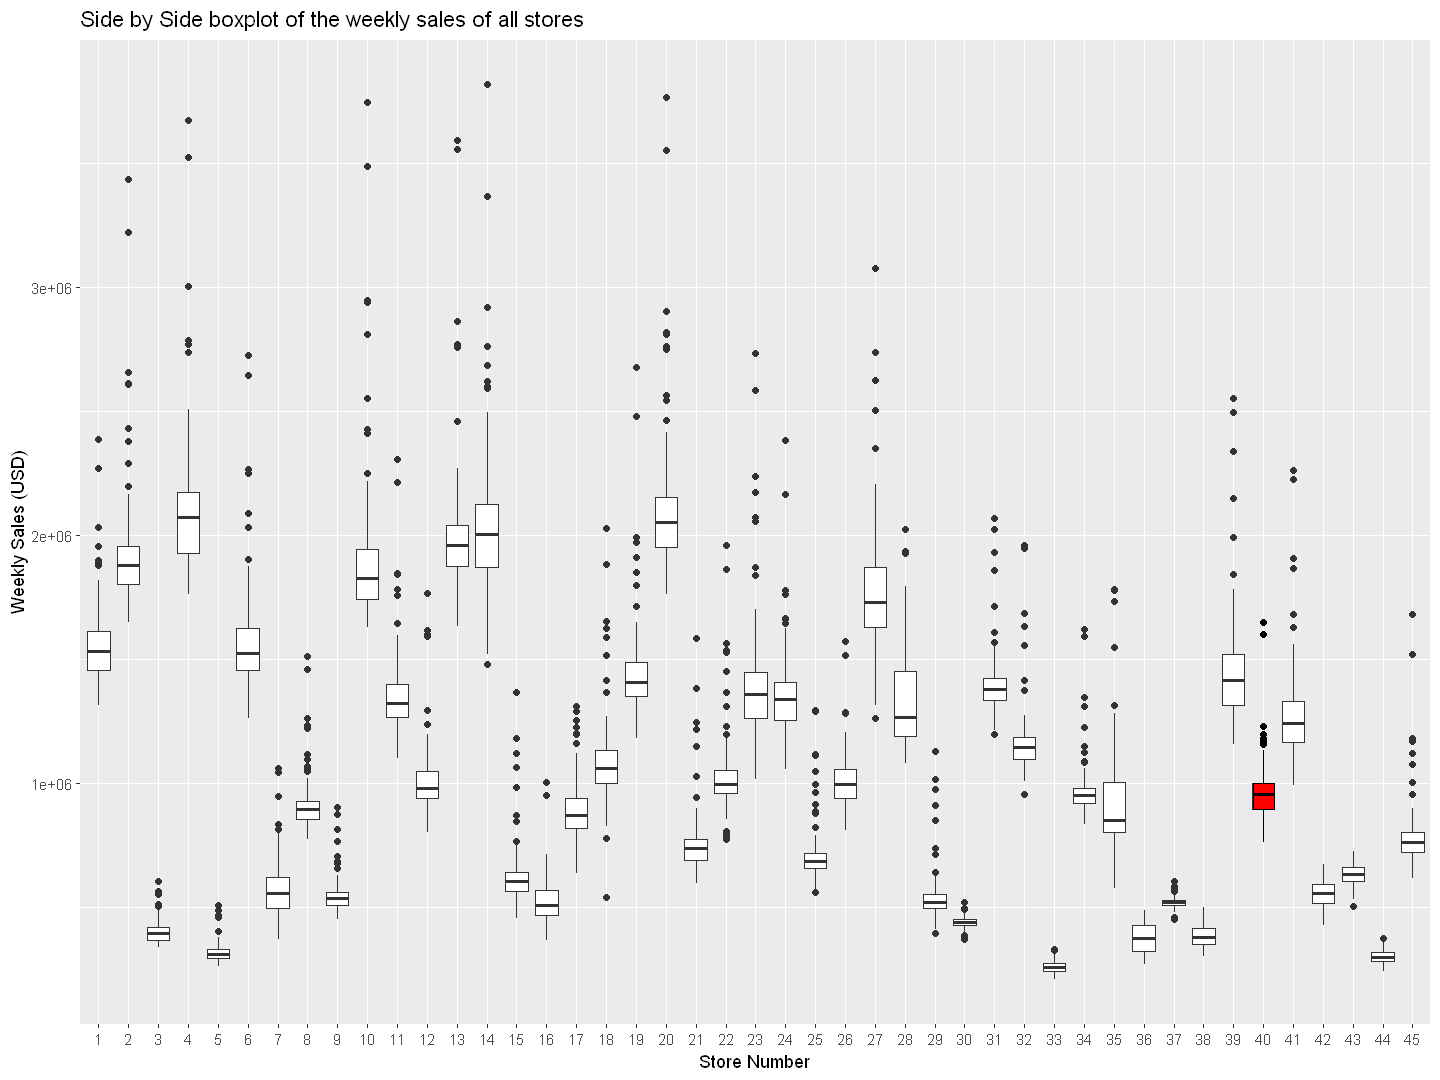

In [ ]:
# First, obtain the summary statistics for each store
data_summary = data |> group_by(Store) |> summarize(mean_weekly_sales = mean(Weekly_Sales), var_weekly_sales = var(Weekly_Sales)) |> mutate(rank_mean_weekly_sales = rank(mean_weekly_sales), rank_var_weekly_sales = rank(var_weekly_sales)) |> mutate(sum_of_ranks = rank_mean_weekly_sales + rank_var_weekly_sales)

# Then raange the rows based on the overall rank
data_summary = data_summary |> arrange(sum_of_ranks) 

# Extract the store number we choose (the store with median combined rank)
chosen_store = data_summary[round(nrow(data_summary)/2, 0), 1] |> pull()
print(chosen_store)

# Set ggplot size
options(repr.plot.width = 12, repr.plot.height = 9)

# Create a boxplot that plots the individual stores (with their store number recorded) against their weekly sales 
ggplot(data = data, aes(x = factor(Store), y = Weekly_Sales)) +
  geom_boxplot() +
  geom_boxplot(data = subset(data, factor(Store) == "40"), 
               aes(x = factor(Store), y = Weekly_Sales),
               fill = "red", color = "black", width = 0.7) +
  labs(title = "Side by Side boxplot of the weekly sales of all stores", x = "Store Number", y = "Weekly Sales (USD)")

The whole dataset was then filtered to only entries that were from store 40

In [15]:
# Get the data for the store we chose
store_40 = data |> filter(Store == chosen_store)
head(store_40)
tail(store_40)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
,<int>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,40,05-02-2010,1001944,0,-9.73,2.79,131.53,5.892
2,40,12-02-2010,955338,1,-6.20,2.77,131.59,5.892
3,40,19-02-2010,916289,0,-2.31,2.75,131.64,5.892
4,40,26-02-2010,863917,0,0.73,2.75,131.69,5.892
5,40,05-03-2010,990152,0,1.54,2.77,131.74,5.892
6,40,12-03-2010,899352,0,1.72,2.81,131.78,5.892


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
,<int>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
138,40,21-09-2012,899768,0,12.29,4.06,138.65,4.156
139,40,28-09-2012,919595,0,10.54,4.02,138.74,4.156
140,40,05-10-2012,1069112,0,14.01,4.03,138.83,4.145
141,40,12-10-2012,982523,0,8.53,4.03,138.91,4.145
142,40,19-10-2012,918170,0,7.96,4.00,138.83,4.145
143,40,26-10-2012,921265,0,9.81,3.92,138.73,4.145


In this analysis, store 40 was selected as the representative store. A boxplot of weekly sales across all stores confirmed that store 40's sales patterns are reasonable and reflective of the general trends observed in the dataset, since the mean and variance of store 40’s weekly sales seem to be fairly average across all stores. Our store selection process ranks the stores by weekly sales, as well as its variance of weekly sales, and takes the sum of the ranks. The store with the median sum of ranks (store 40)  is selected to increase the likelihood of the selected store being able to well represent the key statistical characteristics of the entire dataset.

Also, 2 outlier points (data points that have a weekly sales above $1,500,000) were removed to avoid a biased model and have a more accurate model selection (performed below). This is because the 2 outliers will increase the standard errors of our estimated coefficients, thus increasing the p-value, and the likelihood that the covariate is removed during the model selection process (Type 2 error where the null hypothesis of the covariate having slope = 0 is failed to be rejected).

### **Exploratory Data Analysis**

Based on the store we chosen (store 40), we then conduct data visualization of the response variable and covariates to do preliminary data analysis before using the regression model.

First, 4 scatter plots **Weekly Sales vs. the four continuous variables** (CPI, Unemployment, Fuel Price, and Temperature), **categorized by Holiday_Flag** were created to preliminarily observe how each covariate (along with holiday flag interactions) affects the weekly sales.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


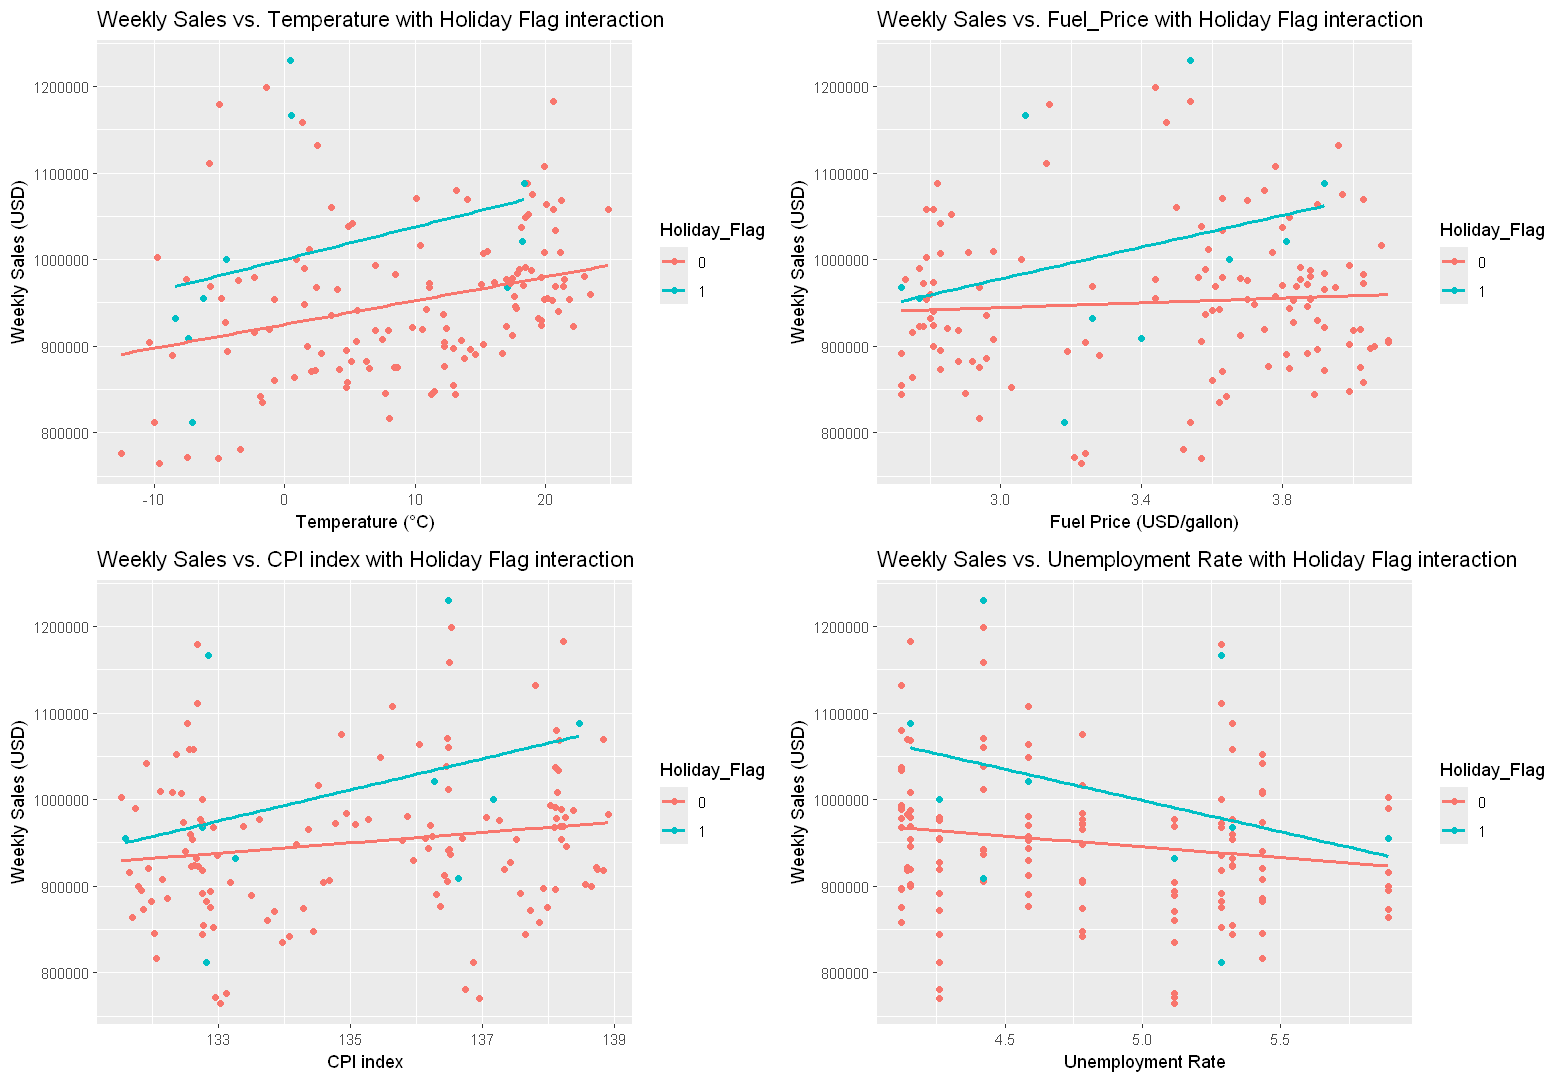

In [52]:
# Weekly Sales vs. Temperature including Holiday Flag interaction
temp_holiday_plot = ggplot(data = store_40, aes(x = Temperature, y = Weekly_Sales, col = Holiday_Flag)) +
  geom_point() + 
  labs(title = "Weekly Sales vs. Temperature with Holiday Flag interaction", x = "Temperature (°C)", y = "Weekly Sales (USD)") +
  geom_smooth(method = "lm", se = FALSE)


# Weekly Sales vs. Fuel Price including Holiday Flag interaction
fuel_holiday_plot = ggplot(data = store_40, aes(x = Fuel_Price, y = Weekly_Sales, col = Holiday_Flag)) +
  geom_point() + 
  labs(title = "Weekly Sales vs. Fuel_Price with Holiday Flag interaction", x = "Fuel Price (USD/gallon)", y = "Weekly Sales (USD)") +
  geom_smooth(method = "lm", se = FALSE)

# Weekly Sales vs. CPI
cpi_holiday_plot = ggplot(data = store_40, aes(x = CPI, y = Weekly_Sales, col = Holiday_Flag)) +
  geom_point() + 
  labs(title = "Weekly Sales vs. CPI index with Holiday Flag interaction", x = "CPI index", y = "Weekly Sales (USD)") +
  geom_smooth(method = "lm", se = FALSE)

# Weekly Sales vs. Unemployment
unemployment_holiday_plot = ggplot(data = store_40, aes(x = Unemployment, y = Weekly_Sales, col = Holiday_Flag)) +
  geom_point() + 
  labs(title = "Weekly Sales vs. Unemployment Rate with Holiday Flag interaction", x = "Unemployment Rate", y = "Weekly Sales (USD)") +
  geom_smooth(method = "lm", se = FALSE)

# Set ggplot size
options(repr.plot.width = 13, repr.plot.height = 9)

# Arrange the plots in a 2x2 grid
grid.arrange(temp_holiday_plot, fuel_holiday_plot, cpi_holiday_plot, unemployment_holiday_plot, nrow = 2, ncol = 2)

Based on early observations from the four plots above, we can initially draw a preliminary conclusion that interaction terms between the four continuous variables (CPI, Unemployment, Fuel Price, and Temperature) and the Holiday_Flag **should** be incorporated into our model. This is suggested by the differing slopes of the response variable (y) against these predictors when comparing holiday (yes) and non-holiday (no) conditions. However, as the differences in slopes are not particularly obvious and the number of data points for holidays is significantly smaller than for non-holidays, this conclusion is tentative and requires further validation. Additional analysis (backward selection) will be conducted later in the modeling process to confirm whether to include these interaction terms or not.

Moreover, we drew the boxplot of weekly sales, categorized by holiday flag (shown below), from which we can observe that there is significant difference of sales between weeks that have a holiday and weeks that do not have a holiday within. Thus, the variable Holiday Flag should be included in our model, which is shown below.

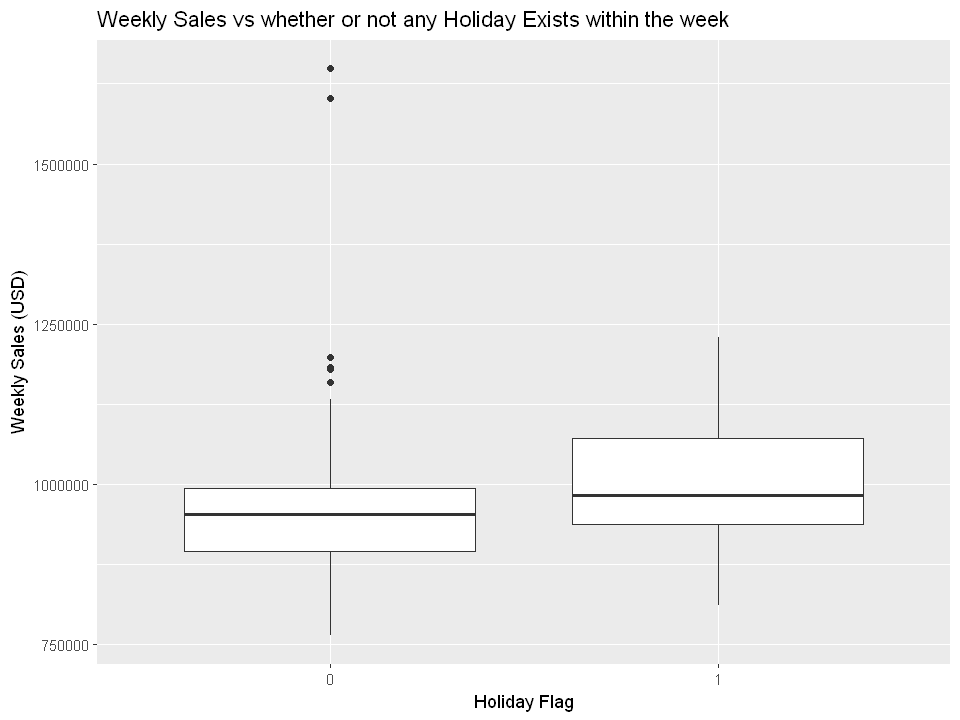

In [33]:
# Set ggplot size
options(repr.plot.width = 8, repr.plot.height = 6)

# Create a boxplot to illustrate the weekly sales between the 2 holiday groups
ggplot(data = store_40, aes(x = Holiday_Flag, y = Weekly_Sales)) +
  geom_boxplot() +
  labs(title = "Weekly Sales vs whether or not any Holiday Exists within the week", x = "Holiday Flag", y = "Weekly Sales (USD)")

Furthermore, to assess the relationships between the different features in the dataset, a correlation matrix was computed for the continuous variables (Temperature, Fuel Price, CPI, Unemployment rate and Weekly Sales). The correlation matrix was then visualized using a heatmap, where positive correlations are represented by cool colors (blues), while negative correlations are shown in warm colors (reds). Variables with strong correlations (close to 1 or -1) are indicated by more intense colors, while weak or no correlations (around 0) are shown by lighter shades.

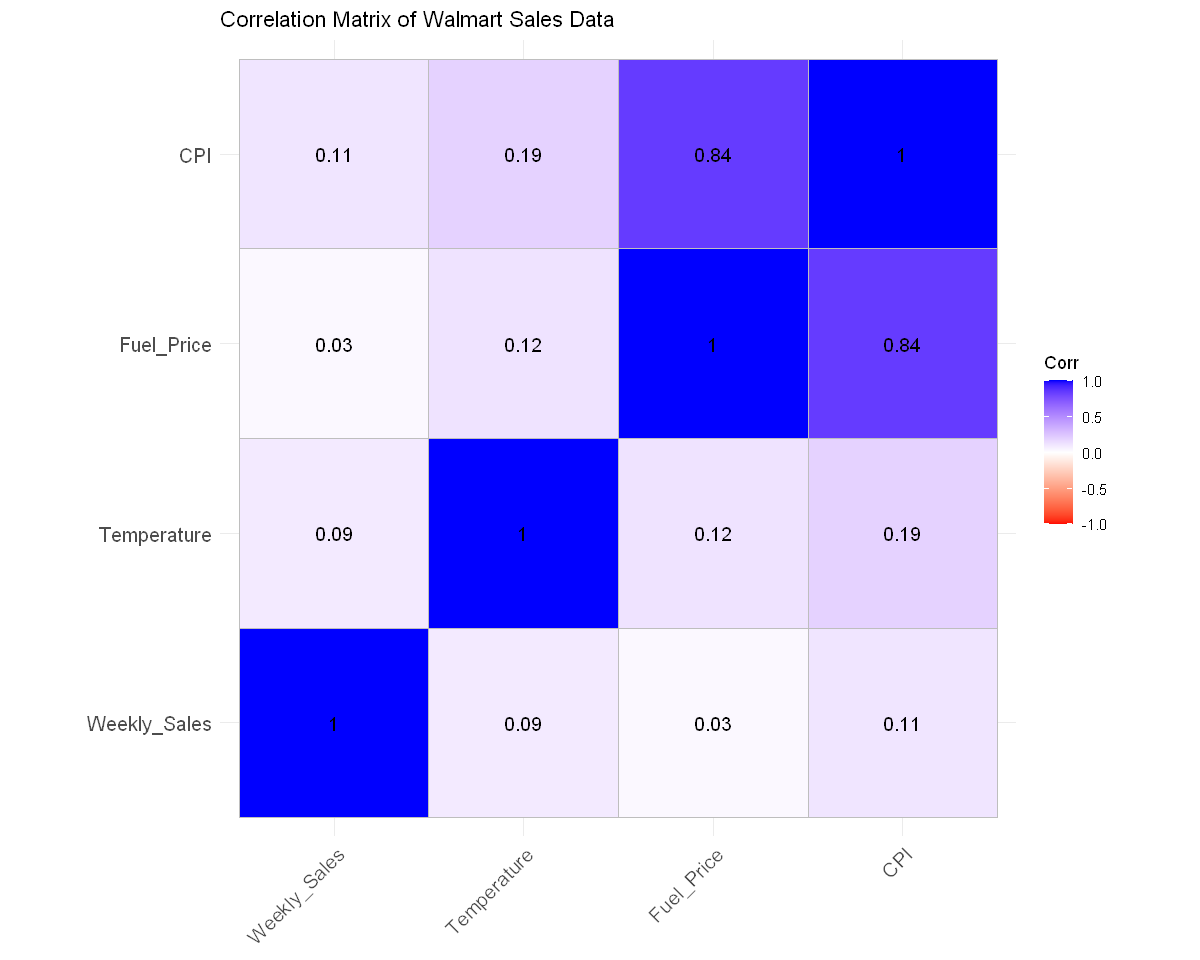

In [41]:
# Set ggplot size
options(repr.plot.width = 10, repr.plot.height = 8)

# Create a correlation matrix to illustrate the strength of relationship between variables
correlation_matrix=cor(store_40[,c('Weekly_Sales','Temperature','Fuel_Price','CPI')])
ggcorrplot(correlation_matrix,lab=TRUE,colors=c("red","white","blue"))+
ggtitle("Correlation Matrix of Walmart Sales Data")

From the heatmap, we observe that the response variable has positive relationship with Temperature, Fuel Price, CPI, and negative relationship with Unemployment rate. Further, Unemployment rate has strong correlation with Fuel Price and CPI, which may impose the risk of multicollinearity in our model if all these three variables are included. Therefore, a multicollinearity check is done below using the VIF.

### **Multicollinearity**

As shown in the Correlation Matrix, strong correlations between CPI, Unemployment and Fuel Price is a concern as it makes the fitted model very sensitive. Therefore, the VIF is computed in the table below for all covariates together. It is done by first fitting the full additive model, then calculating the VIF based on that model.

In [39]:
# Full additive model
model <- lm(Weekly_Sales ~ CPI + Fuel_Price + Temperature + Unemployment + Holiday_Flag, data = store_40)
vif_values <- vif(model)

# VIF with all the covariates
print(vif_values)

         CPI   Fuel_Price  Temperature Unemployment Holiday_Flag 
   23.584245     3.660348     1.094752    25.347647     1.046306 


From the result, we can see that CPI and Unemployment are highly correlated (Both with VIF > 10), which would severely increase the sensitivity and error proneness of our fitted mosel. Based on the above heatmap, the correlation between weekly sales and CPI vs Unemployment is approximately the same, but based on the scatterplots, Unemployment exhibits a slightly steeper slope, making it more plausible to keep Unemployment and remove CPI.

To follow up, the CPI was removed and the VIF was recalculated for the remaining variables, indicated in the table below. Now, the VIF for all variables is well below 10, indicating a low possibility for multicollinearity, and is appropriate to proceed with model selection.

In [42]:
# VIF after removing CPI
model_cpi_removed <- lm(Weekly_Sales ~ + Fuel_Price + Temperature + Unemployment + Holiday_Flag, data = store_40)
vif_values_cpi_removed <- vif(model_cpi_removed)

# VIF with vif_values_cpi_removed the covariates
print(vif_values_cpi_removed)

  Fuel_Price  Temperature Unemployment Holiday_Flag 
    3.653674     1.063161     3.688905     1.040579 


### **Model Selection**

A backwards selection algorithm was used to select our model. A simpler and interpretable model is ideal. We began with the full model containing all the covariates and all the interaction terms of the variables with Holiday Flag. So we will start with 7 covariates (or 8 beta parameters) in total: Temperature, Fuel_Price, Unemployment, Holiday_Flag, and the following interaction terms:  Temperature:Holiday_Flag, Fuel_Price:Holiday_Flag, and Unemployment:Holiday_Flag. It was performed at a **15% significance level** because it even kept variables that only slightly contribute to the model, reducing the probability of Type II error, where covariates that actually contribute to the model get removed. Also, a 15% significance level lowers the chance that all covariates get removed, and the final model being the null model. The parameter with a p-value higher than the threshold will be dropped. We then refitted the model using the remaining variables till we obtained a model with all statistically significant covariates.

As mentioned above in the data pre-processing, two outlier data points were firstly removed to ensure a more accurate, less biased model selection process.


In [43]:
## First remove the outliers 
store_40 = store_40 |> filter(Weekly_Sales < 1500000)
## Perform the model selection

models = list()

# Start with full model with 7 covariates
models[[1]] = lm(Weekly_Sales ~ Temperature + Fuel_Price + Unemployment + Holiday_Flag + Temperature:Holiday_Flag + Fuel_Price:Holiday_Flag + Unemployment:Holiday_Flag, data = store_40)

# Second Model with Fuel_Price:Holiday_Flag interaction removed
models[[2]] = lm(Weekly_Sales ~ Temperature + Fuel_Price + Unemployment + Holiday_Flag + Temperature:Holiday_Flag + Unemployment:Holiday_Flag, data = store_40)

# Third Model with Temperature:Holiday_Flag interaction removed
models[[3]] = lm(Weekly_Sales ~ Temperature + Fuel_Price + Unemployment + Holiday_Flag + Unemployment:Holiday_Flag, data = store_40)

# Fourth Model with Unemployment:Holiday_Flag interaction removed
models[[4]] = lm(Weekly_Sales ~ Temperature + Fuel_Price + Unemployment + Holiday_Flag, data = store_40)

# Final Model with Unemployment:Holiday_Flag interaction removed
models[[5]] = lm(Weekly_Sales ~ Temperature + Unemployment + Holiday_Flag, data = store_40)


# Print out the summary of the final model and full model
summary(models[[5]])


Call:
lm(formula = Weekly_Sales ~ Temperature + Unemployment + Holiday_Flag, 
    data = store_40)

Residuals:
    Min      1Q  Median      3Q     Max 
-163807  -53483  -13022   46399  276879 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1026548.8    65088.2  15.772  < 2e-16 ***
Temperature      2642.8      752.8   3.511 0.000606 ***
Unemployment   -21033.5    13194.0  -1.594 0.113201    
Holiday_Flag1   78438.3    28163.9   2.785 0.006110 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 84230 on 137 degrees of freedom
Multiple R-squared:  0.1347,	Adjusted R-squared:  0.1158 
F-statistic:  7.11 on 3 and 137 DF,  p-value: 0.0001785


**Variables Removed in the Backwards Selection Process**

1. Fuel_Price:Holiday_Flag interaction (P-value: 0.931)
2. Temperature:Holiday_Flag interaction (P-value: 0.850)
3. Unemployment:Holiday_Flag interaction (P-value: 0.458)
4. Fuel_Price (P-value: 0.244)

Our final model has only three variables- Temperature, Unemployment, and Holiday_Flag (without any interactions). These three variables are shown to be statistically significant, with p-values less than 0.15. 

To verify our intuition from the preliminary observations in the scatterplots above, nearly identical scatterplots for the continuous covariates (Temperature and Unemployment), and a boxplot for the categorical variable (holiday flag) were recreated to visually verify whether or not the covariates we expected to be kept from the preliminary analysis were kept in the final model, this is true. 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


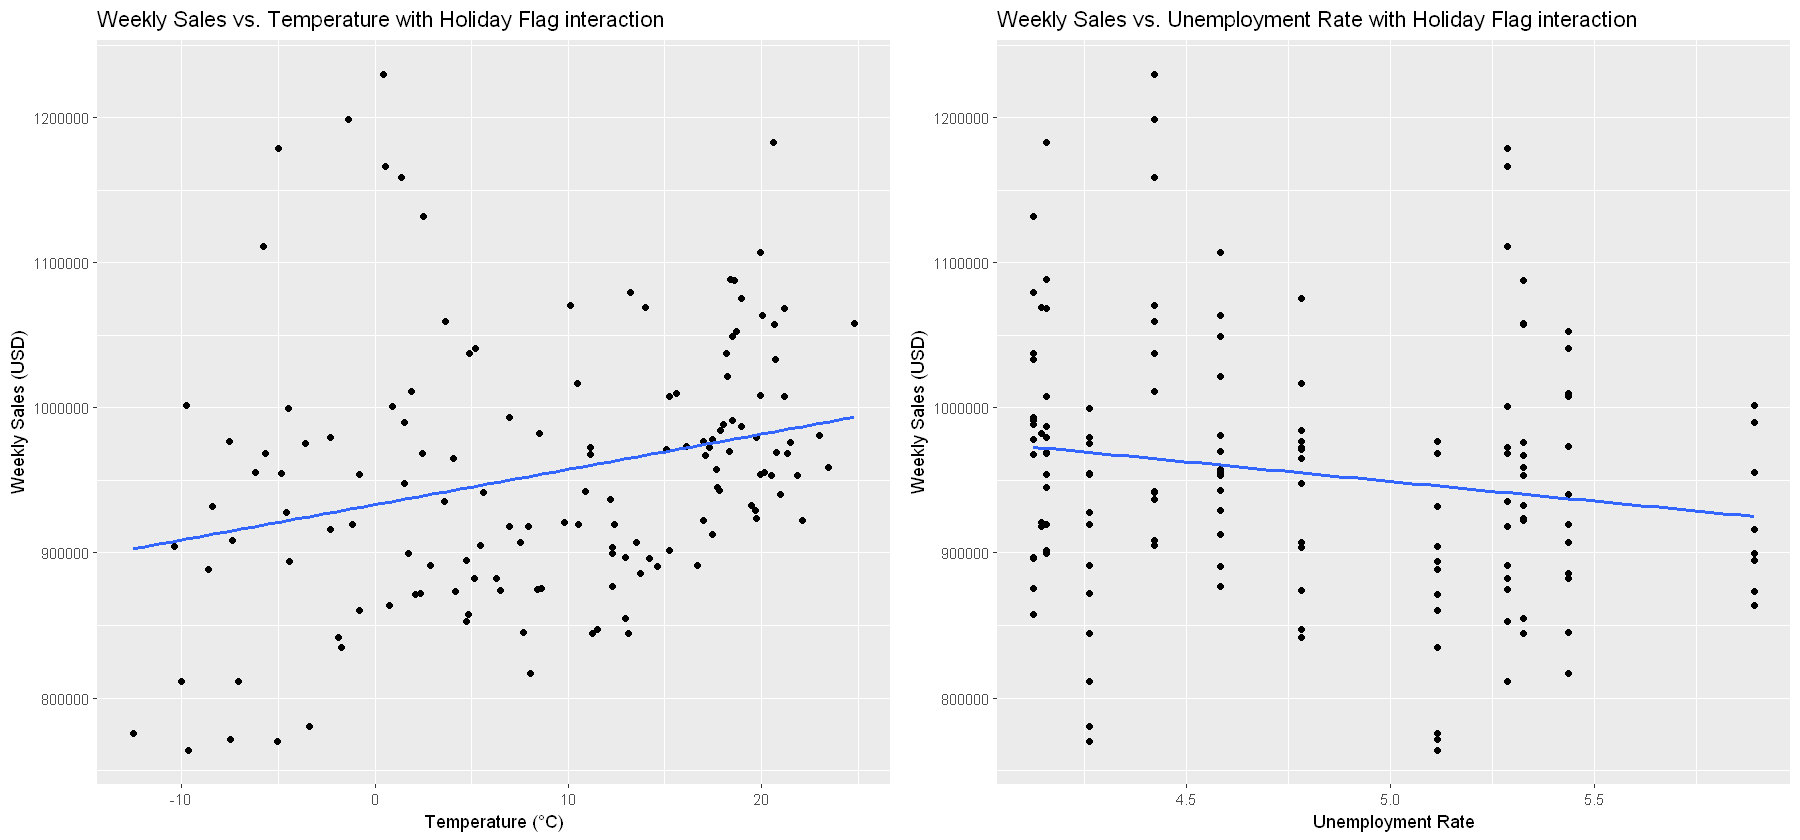

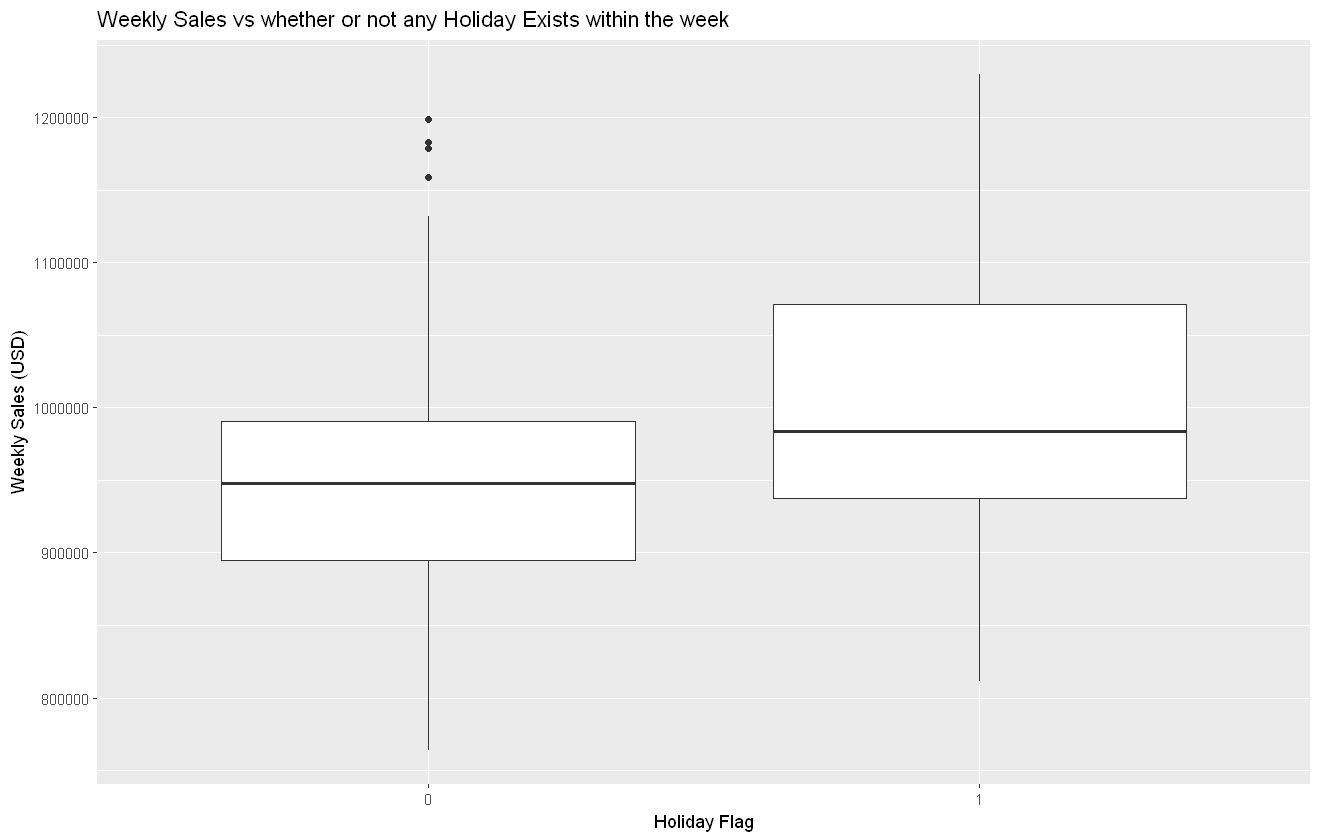

In [53]:
# Pretty much replotting the scatterplots above, but this time without the interaction (since they were removed in the backwards selection process)
# Weekly Sales vs. Temperature
temp_plot = ggplot(data = store_40, aes(x = Temperature, y = Weekly_Sales)) +
  geom_point() + 
  labs(title = "Weekly Sales vs. Temperature with Holiday Flag interaction", x = "Temperature (°C)", y = "Weekly Sales (USD)") +
  geom_smooth(method = "lm", se = FALSE)

# Weekly Sales vs. Unemployment
unemployment_plot = ggplot(data = store_40, aes(x = Unemployment, y = Weekly_Sales)) +
  geom_point() + 
  labs(title = "Weekly Sales vs. Unemployment Rate with Holiday Flag interaction", x = "Unemployment Rate", y = "Weekly Sales (USD)") +
  geom_smooth(method = "lm", se = FALSE)

holiday_flag_boxplot = ggplot(data = store_40, aes(x = Holiday_Flag, y = Weekly_Sales)) +
  geom_boxplot() +
  labs(title = "Weekly Sales vs whether or not any Holiday Exists within the week", x = "Holiday Flag", y = "Weekly Sales (USD)")

# Set size
options(repr.plot.width = 15, repr.plot.height = 7)

# Arrange so they are beside each other
grid.arrange(temp_plot, unemployment_plot, nrow = 1, ncol = 2)

# Set size again
options(repr.plot.width = 11, repr.plot.height = 7)
holiday_flag_boxplot

From the recreated plots, we see that all covariates kept in the final model showed correlations in the scatter plots and boxplots respectively, further verifying intuition from the preliminary observations above.

The formula for our fitted model is: **y_hat = 1026548.8 + 2642.8*x1 - 21033.5*x2 + 78438.3*z**, where **y_hat** = fitted weekly sales, **x1** = Temperature, **x2** = Unemployment, **z** = Holiday flag dummy var.
Based on the fitted model, in degrees Celsius increase in temperature, the average weekly sales is expected to increase by $2642.80 while holding other covariates constant. For each % increase Unemployment rate, the average weekly sales is expected to decrease by $21033.50 while holding other covariates constant. For a week that contains a holiday, the weekly sales are expected to be on average $78438.30 higher than a week with no holidays.

To examine the adequacy of the final model, we compare the R-squared  and Adjusted R-squared values between the full model and the final simpler model.

In [72]:
# Print the R^2 and adj R^2 from the final model summary
r2 = round(summary(models[[5]])$r.squared, 2)
print(paste("R^2:", r2))

adj_r2 = round(summary(models[[5]])$adj.r.squared, 2)
print(paste("Adjusted R^2:", adj_r2))

[1] "R^2: 0.13"


[1] "Adjusted R^2: 0.12"


We observe that the R-squared and adjusted R-squared are low. R-squared is 0.135 for the simpler model. This means only 13.5% of the variance in the response variable, weekly sales, is explained by our model. For the full model, the model explains 14.7% of the variation in the response variable, weekly sales, which is normal because the R^2 never decreases as more covariates are added. However, given that the final model with less covariates explains most of the variation in the response, and has a higher adjusted R^2 compared to the full model, it is obviously desired over the full model because it is more interpretable, less complex, and fits the data more efficiently.

To assess the fit of our final model, we created a residual plot by plotting the residuals against the fitted values. This allows us to check the satisfaction of the assumption of linearity and homoscedasticity.


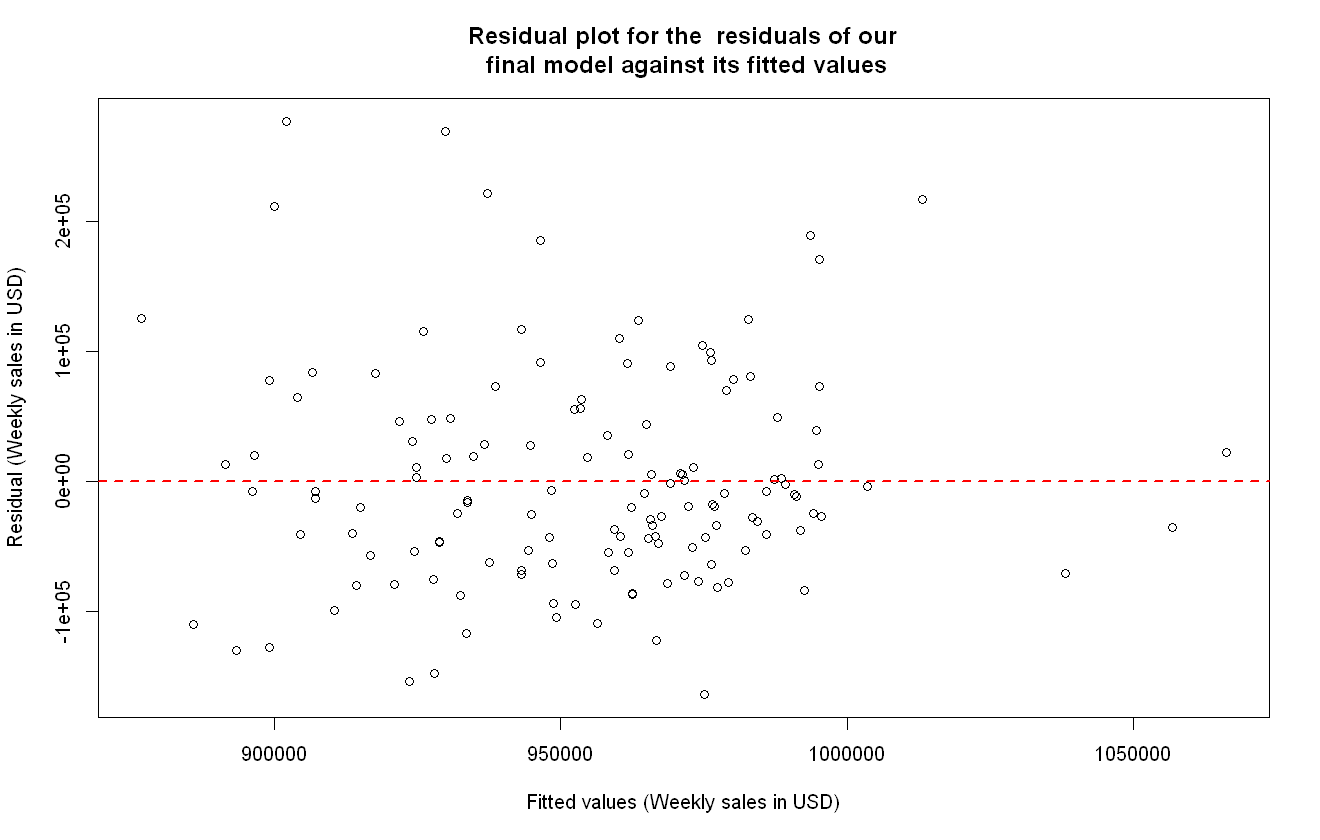

In [73]:
# Residual plot of the fitted values against the residuals
plot(models[[5]]$fitted.values, models[[5]]$residuals, main = "Residual plot for the  residuals of our\n final model against its fitted values", xlab = "Fitted values (Weekly sales in USD)", ylab = "Residual (Weekly sales in USD)")

abline(h = 0, col = "red", lwd = 2, lty = 2)

After examining the residual plot, we observe that the residuals are generally patternless and centered around 0, with the exception of a few outliers. Ignoring the few outliers, the residuals appear to be randomly scattered, suggesting that the assumption of linearity is likely satisfied. In regards to the assumption of homoscedasticity, although the residuals exhibit slightly higher variance for lower fitted values, this could be attributed to random variability within our dataset. However, ignoring some outliers on the right and the top of the plot, the remaining residuals appear to have relatively constant variance. This suggests that the assumption of constant variance, or homoscedasticity, is likely satisfied. Therefore, transformations and using a quadratic model is not needed.

---

## **Conclusion**

### **Results**

In our project, to avoid the issue of multicollinearity, we had to extract data from a relatively representative Walmart store in the dataset. We then used a linear regression model to analyze the impact of existing variables on weekly sales. The final model achieved higher R^2 and adjusted R^2 values compared to the full model, indicating that the final model provided a better fit. **Therefore, compared to the full model, the final model retained only temperature, unemployment, and holiday flag. This means that among all the covariates in the full model, only these three covariates were considered to influence the weekly sales of a Walmart store in some way.**

**Interpreting the correlations in our model contextually:** The positive correlation between Temperature and weekly sales could indicate that consumers are more inclined to buy groceries when it is warmer, as certain weather conditions associated with cold temperatures, such as snowy or icy weather, could deter consumers from driving to Walmart those weeks with low temperatures, consequently lowering sales. The negative correlation between unemployment and sales could potentially mean that the result of a higher unemployment rate could be a weaker economy, causing people to spend less altogether. Finally, on weeks with holidays, higher weekly sales could be caused by the fact that there tend to be more parties and celebrations on holidays, encouraging people to buy more food and necessities for their parties, and consequently, spending more, resulting in higher weekly sales.

### **Limitations**

***The R^2 and adjusted R^2 statistic is low, meaning our model (both full model and our final model) does not do a very good job at describing the variation in the response:***

In real-world business practices, weekly sales are influenced by a wider range of factors, including local market competition, marketing spend, lifestyle habits, wealth disparities between cities or communities, transportation, mall size, and other quantifiable or non-quantifiable factors. However, the available dataset provides only a limited number of variables. As a result, our model had to omit many variables that may have a relationship with weekly sales, leading to poor model fit and limiting its ability to effectively explain the data.

***Our model is not very generalizable:***

Due to the limitations of our current knowledge, we were unable to effectively address the multicollinearity issue across different stores. As a result, we had to select data from a relatively representative store (the store with median sales) among all stores in an attempt to make the model relatively more generalizable. However, this approach still did not resolve the issue. Since our model fitting was based solely on the data from one store, its performance on data from other stores is poor, making it difficult to achieve generalizability.

***Outliers were removed during model selection:***

Although outliers were removed during model selection to allow for a more accurate, unbiased final model, it did have its drawbacks. Although outliers are annoying, they sometimes carry significant information about the dataset that hasn’t been discovered yet, especially since they are usually not the results of entry errors. By removing outliers, you could be discarding valuable information that could be important statistically.

***Improvements we could potentially make:***

To better optimize our model, we could consider incorporating additional variables into the model. For factors that are inherently non-quantifiable, we can attempt to quantify them using a scoring approach. For instance, we could assign scores from 1 to 10 to represent the varying levels of high consumer willingness across different regions based on comparative analysis and incorporate this score as a variable into the model. At the same time, we may also explore potential nonlinear relationships between sales and the variables to enhance the model's ability to explain the dependent variable. Finally, we will explore new methods to address the issue of multicollinearity, aiming to incorporate data from more stores into our model fitting process.
